$$
H = \frac{|p|^2}2 + \alpha \sin(\theta t) s + \frac{\gamma}{|q|}
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fast")  # alt: 'seaborn-white'

# plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha * np.sin(self.theta * t)

    def V(self, q, t):
        return self.gamma / np.linalg.norm(q, ord=2)

    def Vq(self, q, t):
        return -q * self.gamma / np.linalg.norm(q, ord=2) ** 3

    def lag(self, q, v, z, t):
        return 0.5 * np.linalg.norm(v) ** 2 - self.V(q, t) - self.f(t) * z

    def lagq(self, q, v, z, t):
        return -self.Vq(q, t)

    def lagv(self, q, v, z, t):
        return v

    def lagz(self, q, v, z, t):
        return -self.f(t)

    def energy(self, p, q, z, t):
        return 0.5 * np.linalg.norm(p, ord=2) ** 2 + self.f(t) + self.V(q, t)

In [4]:
e = 0.4
init_ecc = lambda e: [
    np.array([1.0 - e, 0.0]),
    np.array([0.0, np.sqrt((1 + e) / (1 - e))]),
]
init = init_ecc(e)

energy = lambda pq, z, tspan: np.array(
    [tpk.energy(pq[:, 0][i], pq[:, 1][i], z[i], t) for i, t in enumerate(tspan)]
)

## RK4 comparisons

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


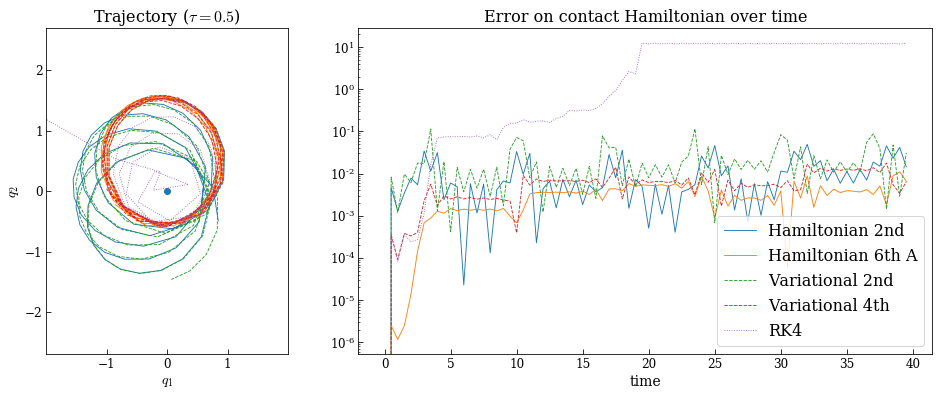

In [5]:
tpk = TimePerturbedKepler(-0.07, 2 * np.pi, -1)
dt = 0.5
tf = 40

tspan = np.arange(0.0, tf, dt)

for (p0, q0) in [init]:

    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0, q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    #     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    #     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    #     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)

    fig = plt.figure(figsize=(16, 6))
    # fig.suptitle(f"$\\tau={dt}$")

    gs = matplotlib.gridspec.GridSpec(1, 3, figure=fig)

    axo = fig.add_subplot(gs[0, 0])

    axo.set_title(f"Trajectory ($\\tau={dt}$)", fontsize=16)
    axo.plot(sol[:, 1, 0], sol[:, 1, 1], linewidth=0.9, label="Hamiltonian 2nd")
    axo.plot(solm[:, 1, 0], solm[:, 1, 1], linewidth=0.9, label="Hamiltonian 6th A")

    axo.plot(
        solsc[:, 1, 0], solsc[:, 1, 1], "--", linewidth=0.9, label="Variational 2nd"
    )
    axo.plot(
        sollag[:, 1, 0], sollag[:, 1, 1], "--", linewidth=0.9, label="Variational 4th"
    )

    axo.plot(
        [rk[2] for rk in solrk],
        [rk[3] for rk in solrk],
        ":",
        linewidth=0.9,
        label="RK4",
    )

    #     axo.plot(sole[:,1,0],
    #              sole[:,1,1],
    #              linewidth=0.9, label="Hamiltonian 6th e")
    #     axo.plot(solb[:,1,0],
    #              solb[:,1,1],
    #              linewidth=0.9, label="Hamiltonian 6th b")
    #     axo.plot(solc[:,1,0],
    #              solc[:,1,1],
    #              linewidth=0.9, label="Hamiltonian 6th c")

    axo.scatter(0, 0)

    axo.set_aspect("equal", adjustable="box")
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    axo.set_xticks([-1, 0, 1])
    # axo.set_yticks([-1,0,1])
    axo.set_xlabel("$q_1$")
    axo.set_ylabel("$q_2$")
    # axo.legend()

    tspan_ = np.arange(
        0.0, tf, dt / 20
    )  # we could also do /10, there is no noticeable difference
    sol_, sols_, _ = ic.integrate(ic.step6, tpk, tspan_, p0, q0, 0.0)
    ref = energy(sol_, sols_, tspan_)[::20]

    axe = fig.add_subplot(gs[0, 1:])
    axe.set_title("Error on contact Hamiltonian over time", fontsize=16)

    axe.plot(
        tspan,
        np.abs(energy(sol, sols, tspan) - ref),
        linewidth=0.9,
        label="Hamiltonian 2nd",
    )
    axe.plot(
        tspan,
        np.abs(energy(solm, solms, tspan) - ref),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    axe.plot(
        tspan,
        np.abs(energy(solsc, solscs, tspan) - ref),
        "--",
        linewidth=0.9,
        label="Variational 2nd",
    )
    axe.plot(
        tspan,
        np.abs(energy(sollag, sollags, tspan) - ref),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    axe.plot(
        tspan,
        np.abs(
            np.array(
                [
                    tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t)
                    for i, t in enumerate(tspan)
                ]
            )
            - ref
        ),
        ":",
        linewidth=0.9,
        label="RK4",
    )

    axe.legend(loc="lower right")
    axe.set_yscale("log")
    # axe.set_ylabel("Error on contact Hamiltonian")
    axe.set_xlabel("time")

    plt.subplots_adjust(wspace=0.25)

    plt.savefig("K5-30.pdf")
    fig.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


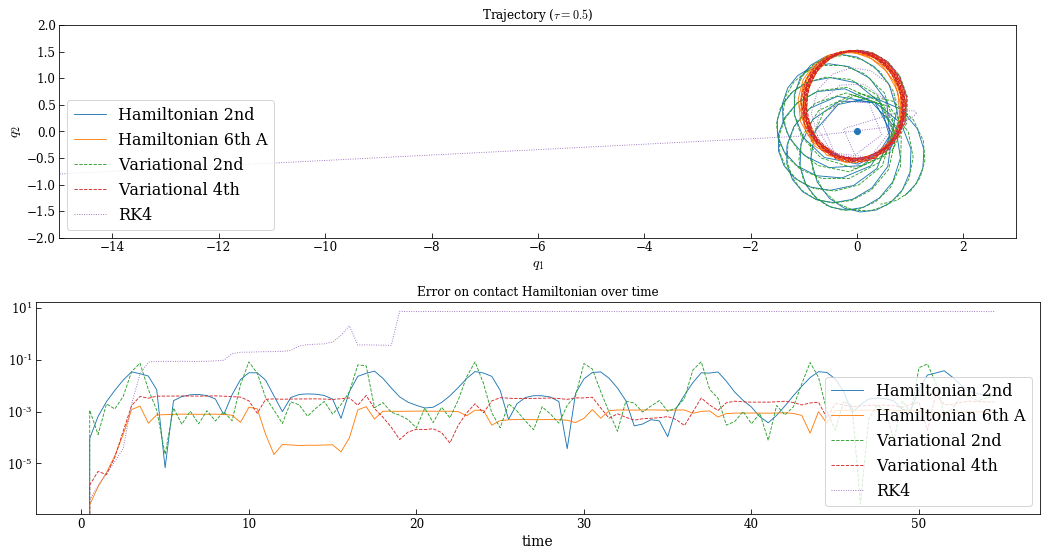

In [6]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 55

tspan = np.arange(0.0, tf, dt)

for (p0, q0) in [init]:
    fig = plt.figure(figsize=(18, 9))
    # plt.title(f"$\\tau={dt}$")

    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0, q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    #     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    #     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    #     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)

    axo = fig.add_subplot(211)
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(sol[:, 1, 0], sol[:, 1, 1], linewidth=0.9, label="Hamiltonian 2nd")
    axo.plot(solm[:, 1, 0], solm[:, 1, 1], linewidth=0.9, label="Hamiltonian 6th A")

    axo.plot(
        solsc[:, 1, 0], solsc[:, 1, 1], "--", linewidth=0.9, label="Variational 2nd"
    )
    axo.plot(
        sollag[:, 1, 0], sollag[:, 1, 1], "--", linewidth=0.9, label="Variational 4th"
    )

    axo.plot(
        [rk[2] for rk in solrk],
        [rk[3] for rk in solrk],
        ":",
        linewidth=0.9,
        label="RK4",
    )

    #     axo.plot(sole[:,1,0],
    #              sole[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6th e")
    #     axo.plot(solb[:,1,0],
    #              solb[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6th b")
    #     axo.plot(solc[:,1,0],
    #              solc[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6nd c")

    axo.scatter(0, 0)

    axo.set_aspect("equal", adjustable="box")

    axo.set_xlim(-15, 3)
    axo.set_ylim(-2, 2)

    axo.set_xlabel("$q_1$")
    axo.set_ylabel("$q_2$")
    axo.legend(loc="lower left")

    tspan_ = np.arange(0.0, tf, dt / 10)
    sol_, sols_, _ = ic.integrate(ic.step6, tpk, tspan_, p0, q0, 0.0)
    ref = energy(sol_, sols_, tspan_)[::10]

    axe = fig.add_subplot(212)
    axe.set_title("Error on contact Hamiltonian over time")

    axe.plot(
        tspan,
        np.abs(energy(sol, sols, tspan) - ref),
        linewidth=0.9,
        label="Hamiltonian 2nd",
    )
    axe.plot(
        tspan,
        np.abs(energy(solm, solms, tspan) - ref),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    axe.plot(
        tspan,
        np.abs(energy(solsc, solscs, tspan) - ref),
        "--",
        linewidth=0.9,
        label="Variational 2nd",
    )

    axe.plot(
        tspan,
        np.abs(energy(sollag, sollags, tspan) - ref),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    axe.plot(
        tspan,
        np.abs(
            np.array(
                [
                    tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t)
                    for i, t in enumerate(tspan)
                ]
            )
            - ref
        ),
        ":",
        linewidth=0.9,
        label="RK4",
    )

    axe.legend(loc="lower right")
    axe.set_yscale("log")
    # axe.set_ylabel("Error on Contact Hamiltonian")
    axe.set_xlabel("time")

    fig.subplots_adjust(hspace=0.3)
    fig.show()

# Convergence of scattering trajectories

In [ ]:
tpk = TimePerturbedKepler(1.7, 2 * np.pi, -1)
tf = 10

(p0, q0) = init_ecc(0.01)

plt.figure(figsize=(18, 12))

subplots = ["131", "132", "133"]

for i, precision in enumerate([10, 100, 1000]):
    dt = 1 / precision
    tspan = np.arange(0.0, tf, dt)
    plt.subplot(subplots[i])
    plt.title(f"$\\tau={dt}$")

    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0, q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    #     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    #     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    #     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)

    plt.plot(sol[:, 1, 0], sol[:, 1, 1], linewidth=0.5, label="Hamiltonian 2nd")
    plt.plot(solm[:, 1, 0], solm[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th A")

    plt.plot(solsc[:, 1, 0], solsc[:, 1, 1], linewidth=0.5, label="Variational 2nd")
    plt.plot(sollag[:, 1, 0], sollag[:, 1, 1], linewidth=0.5, label="Variational 4th")

    plt.plot(
        [rk[2] for rk in solrk], [rk[3] for rk in solrk], linewidth=0.5, label="RK4"
    )

    #     plt.plot(sole[:,1,0],
    #              sole[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6th e")
    #     plt.plot(solb[:,1,0],
    #              solb[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6th b")
    #     plt.plot(solc[:,1,0],
    #              solc[:,1,1],
    #              linewidth=0.5, label="Hamiltonian 6nd c")
    plt.xlabel("$q_1$")
    plt.ylabel("$q_2$")
    plt.scatter(0, 0)

    plt.gca().set_aspect("equal", adjustable="box")

    plt.legend()

plt.show()

## Small eccentricity

In [17]:
(p0, q0) = init_ecc(0.01)  # Plot 0.01, 0.4

tpk = TimePerturbedKepler(-0.07, 2 * np.pi, -1)

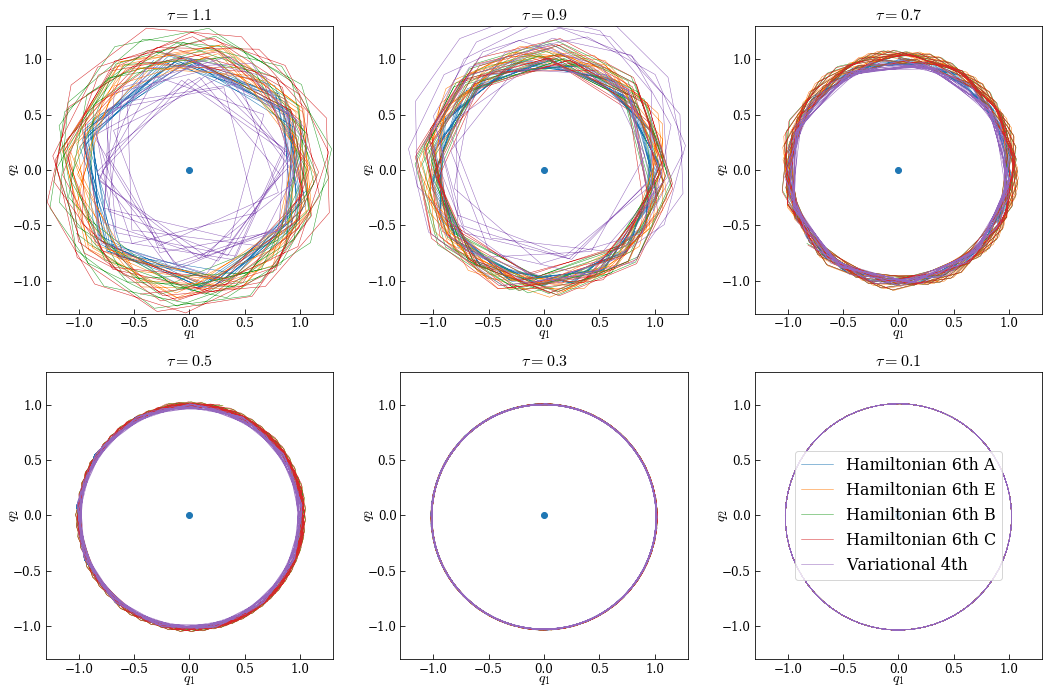

In [18]:
tf = 80
plt.figure(figsize=(18, 18))

for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, _, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt}$", fontsize=16)
    plt.plot(solm[:, 1, 0], solm[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th A")
    plt.plot(sole[:, 1, 0], sole[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th E")
    plt.plot(solb[:, 1, 0], solb[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th B")
    plt.plot(solc[:, 1, 0], solc[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th C")
    plt.plot(sollag[:, 1, 0], sollag[:, 1, 1], linewidth=0.5, label="Variational 4th")

    plt.scatter(0, 0)

    plt.gca().set_aspect("equal", adjustable="box")

    plt.xlim(-1.3, 1.3)
    plt.ylim(-1.3, 1.3)
    plt.xlabel("$q_1$", labelpad=-3)
    plt.ylabel("$q_2$", labelpad=-8)

    if i == 5:
        plt.legend()

plt.savefig("K11_01-80-001.pdf")
plt.show()

In [9]:
tf = 40

dt_factors = [11, 9, 7, 5, 3, 1]
tspan_ = np.arange(0.0, tf, min(dt_factors) / 100)
sol_, sols_, _ = ic.integrate(ic.step6, tpk, tspan_, p0, q0, 0.0)
ref = energy(sol_, sols_, tspan_)

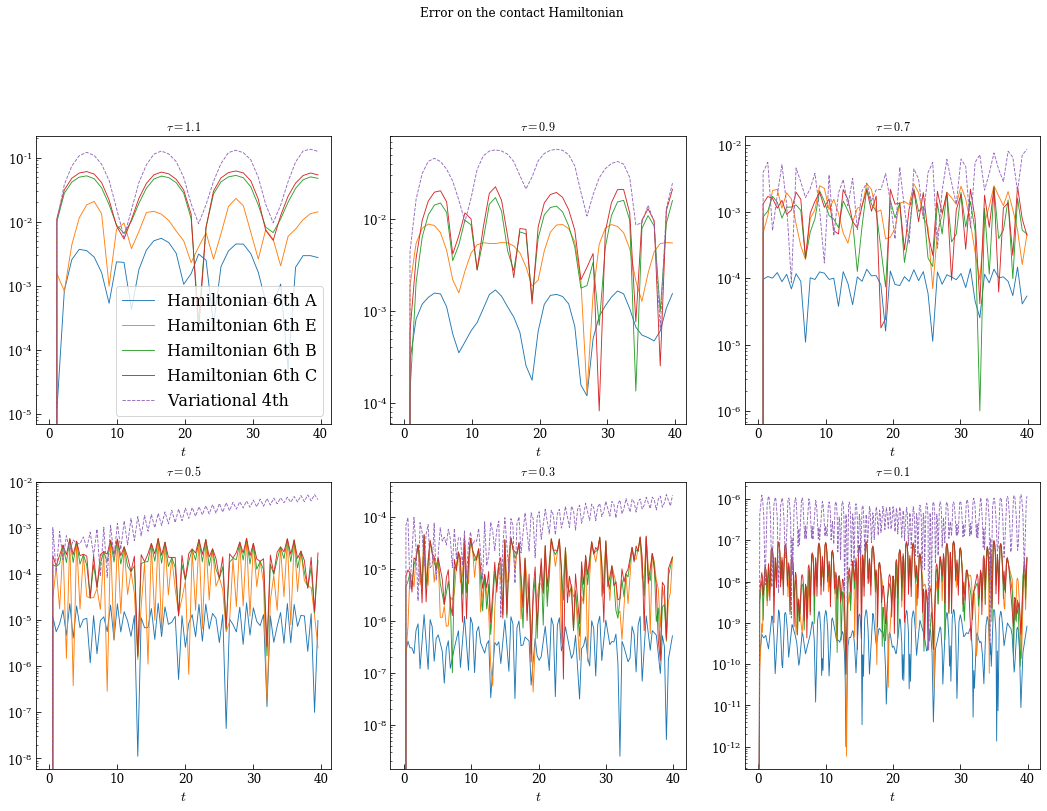

In [10]:
plt.figure(figsize=(18, 18))
plt.suptitle("Error on the contact Hamiltonian")

for i, dt in enumerate(dt_factors):
    tspan = np.arange(0.0, tf, dt / 10)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    ref_ = ref[:: dt * 10]

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt/10}$")

    plt.plot(
        tspan,
        np.abs(energy(solm, solms, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    plt.plot(
        tspan,
        np.abs(energy(sole, soles, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th E",
    )

    plt.plot(
        tspan,
        np.abs(energy(solb, solbs, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th B",
    )

    plt.plot(
        tspan,
        np.abs(energy(solc, solcs, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th C",
    )

    plt.plot(
        tspan,
        np.abs(energy(sollag, sollags, tspan) - ref_),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    plt.yscale("log")

    # plt.ylabel("Error on Contact Hamiltonian")
    plt.xlabel("$t$")

    if i == 0:
        plt.legend(loc="lower right")

plt.show()

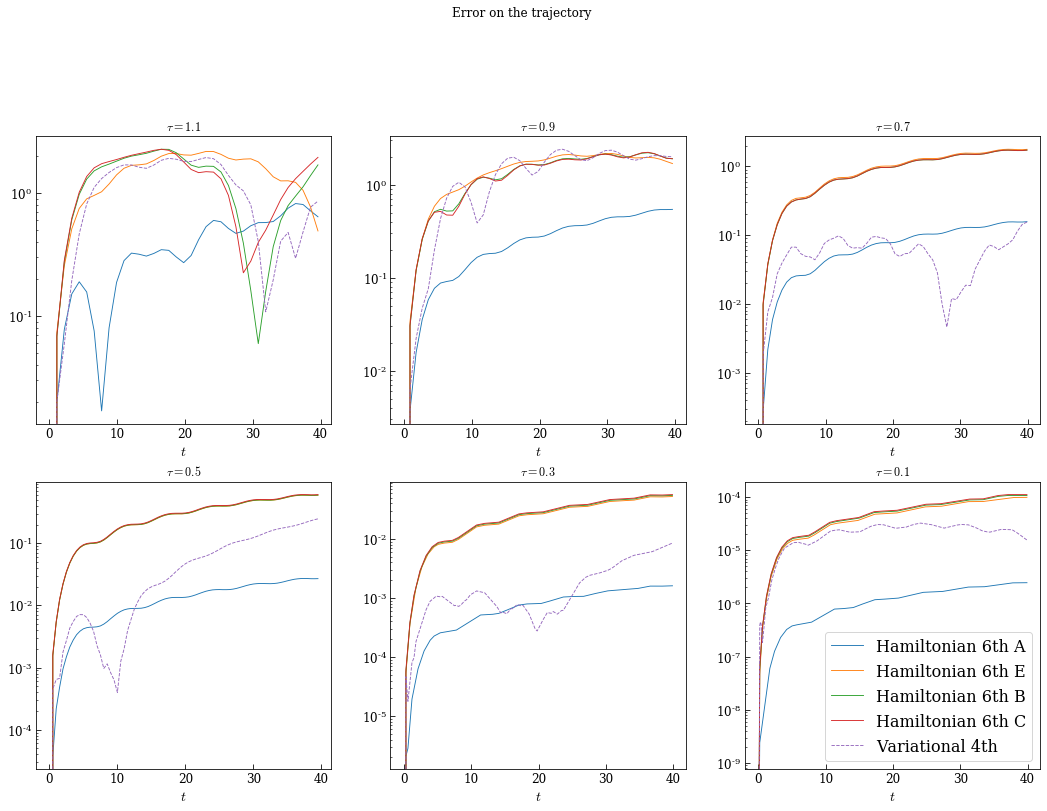

In [11]:
plt.figure(figsize=(18, 18))
plt.suptitle("Error on the trajectory")

for i, dt in enumerate(dt_factors):
    tspan = np.arange(0.0, tf, dt / 10)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    ref_ = sol_[:: dt * 10]

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt/10}$")

    plt.plot(
        tspan,
        np.linalg.norm(solm[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    plt.plot(
        tspan,
        np.linalg.norm(sole[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th E",
    )

    plt.plot(
        tspan,
        np.linalg.norm(solb[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th B",
    )

    plt.plot(
        tspan,
        np.linalg.norm(solc[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th C",
    )

    plt.plot(
        tspan,
        np.linalg.norm(sollag[:, 1] - ref_[:, 1], axis=1),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    plt.yscale("log")

    # plt.ylabel("Error on Contact Hamiltonian")
    plt.xlabel("$t$")

    if i == 5:
        plt.legend(loc="lower right")

plt.show()

## Large eccentricity

In [19]:
(p0, q0) = init_ecc(0.4)

tpk = TimePerturbedKepler(-0.07, 2 * np.pi, -1)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


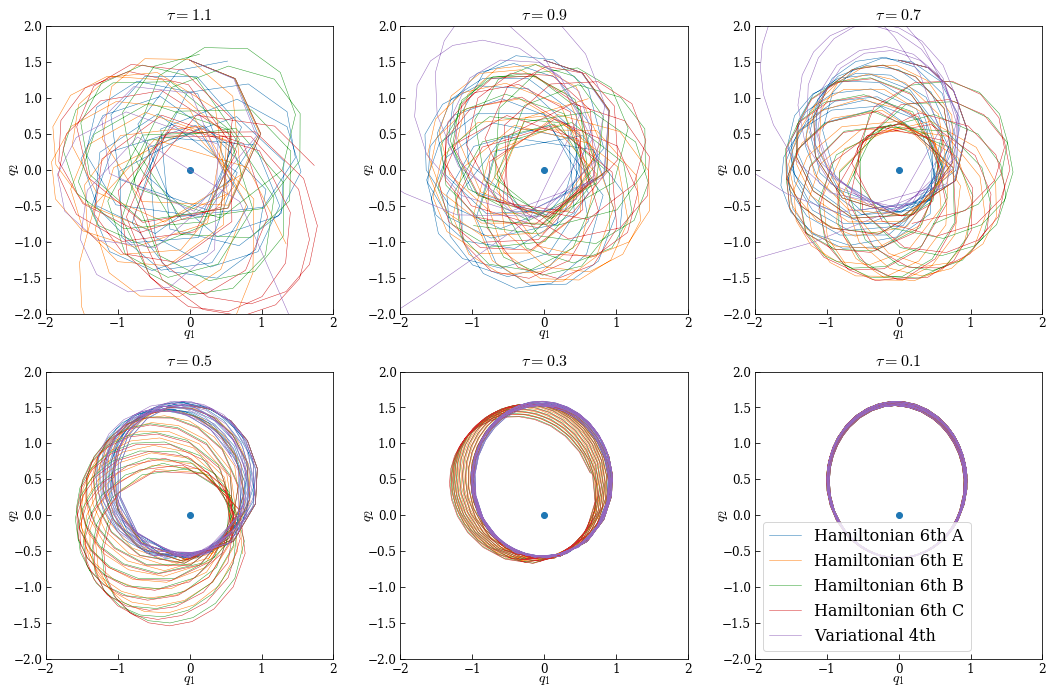

In [20]:
tf = 80

plt.figure(figsize=(18, 18))

for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, _, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt}$", fontsize=16)
    plt.plot(solm[:, 1, 0], solm[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th A")
    plt.plot(sole[:, 1, 0], sole[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th E")
    plt.plot(solb[:, 1, 0], solb[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th B")
    plt.plot(solc[:, 1, 0], solc[:, 1, 1], linewidth=0.5, label="Hamiltonian 6th C")
    plt.plot(sollag[:, 1, 0], sollag[:, 1, 1], linewidth=0.5, label="Variational 4th")

    plt.scatter(0, 0)

    plt.gca().set_aspect("equal", adjustable="box")

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

    plt.xlabel("$q_1$", labelpad=-3)
    plt.ylabel("$q_2$", labelpad=-8)
    if i == 5:
        plt.legend()

plt.savefig("K11_01-80-04.pdf")
plt.show()

In [14]:
tf = 40

dt_factors = [11, 9, 7, 5, 3, 1]
tspan_ = np.arange(0.0, tf, min(dt_factors) / 100)
sol_, sols_, _ = ic.integrate(ic.step6, tpk, tspan_, p0, q0, 0.0)
ref = energy(sol_, sols_, tspan_)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


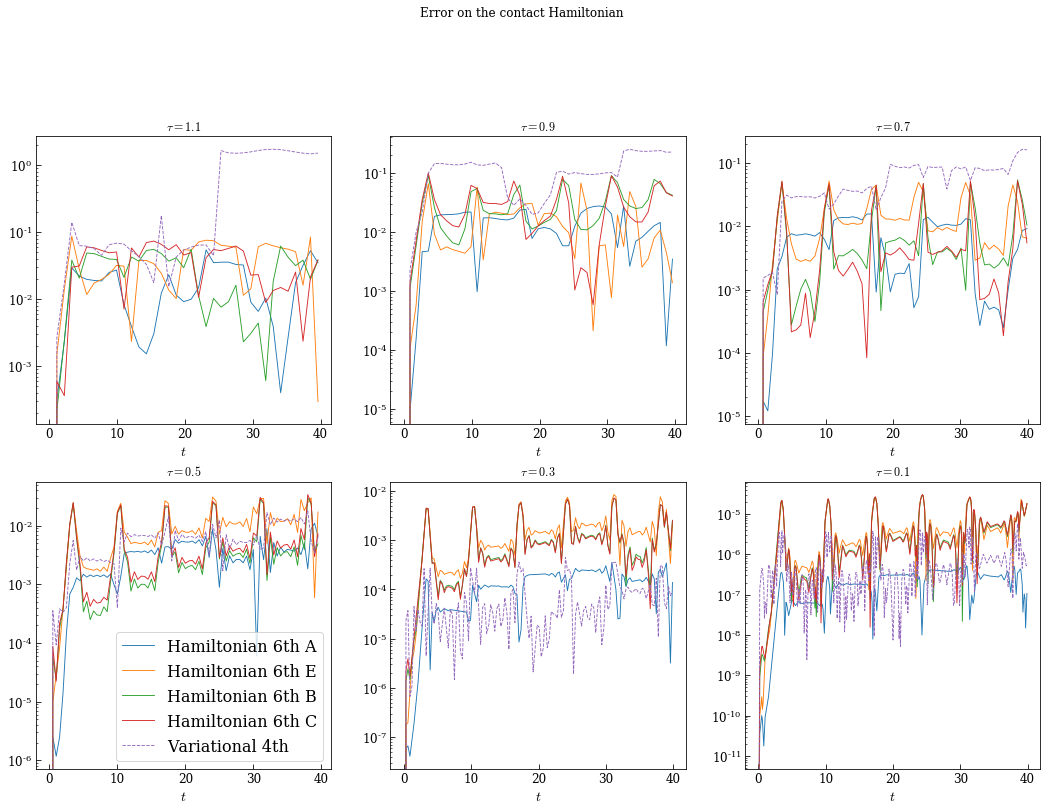

In [15]:
plt.figure(figsize=(18, 18))
plt.suptitle("Error on the contact Hamiltonian")

for i, dt in enumerate(dt_factors):
    tspan = np.arange(0.0, tf, dt / 10)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    ref_ = ref[:: dt * 10]

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt/10}$")

    plt.plot(
        tspan,
        np.abs(energy(solm, solms, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    plt.plot(
        tspan,
        np.abs(energy(sole, soles, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th E",
    )

    plt.plot(
        tspan,
        np.abs(energy(solb, solbs, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th B",
    )

    plt.plot(
        tspan,
        np.abs(energy(solc, solcs, tspan) - ref_),
        linewidth=0.9,
        label="Hamiltonian 6th C",
    )

    plt.plot(
        tspan,
        np.abs(energy(sollag, sollags, tspan) - ref_),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    plt.yscale("log")

    # plt.ylabel("Contact Hamiltonian")
    plt.xlabel("$t$")

    if i == 3:
        plt.legend(loc="lower right")

plt.show()

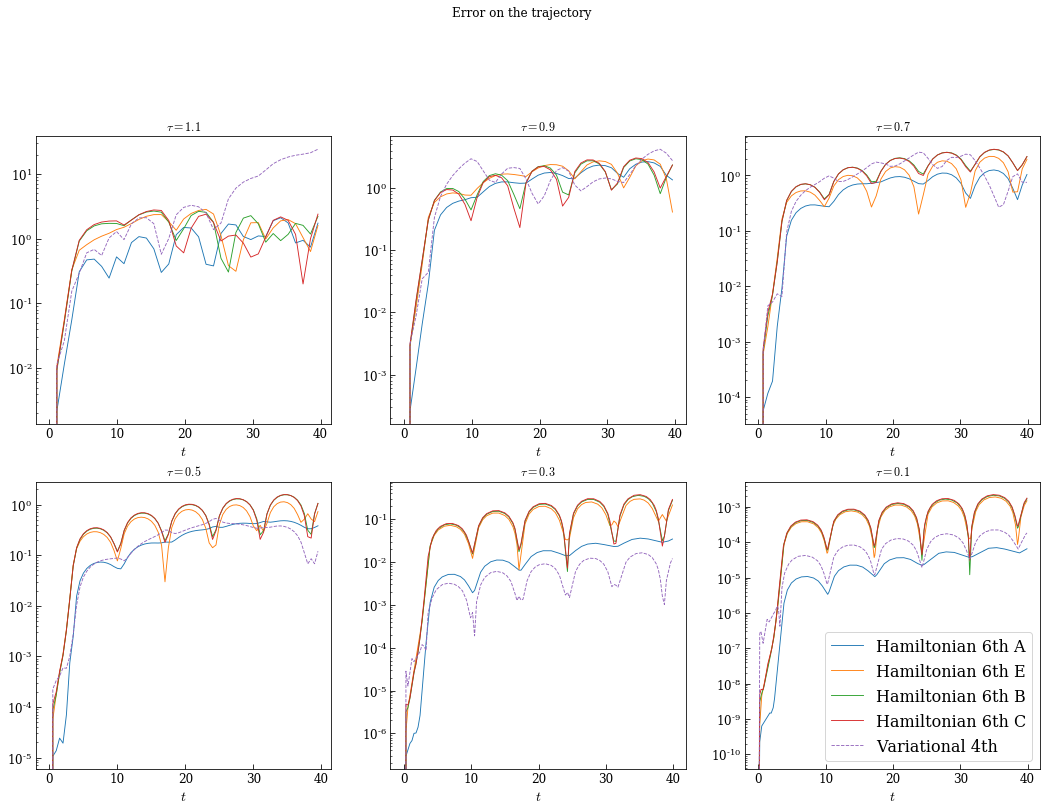

In [16]:
plt.figure(figsize=(18, 18))
plt.suptitle("Error on the trajectory")

for i, dt in enumerate(dt_factors):
    tspan = np.arange(0.0, tf, dt / 10)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    ref_ = sol_[:: dt * 10]

    plt.subplot(3, 3, i + 1)

    plt.title(f"$\\tau={dt/10}$")

    plt.plot(
        tspan,
        np.linalg.norm(solm[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th A",
    )

    plt.plot(
        tspan,
        np.linalg.norm(sole[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th E",
    )

    plt.plot(
        tspan,
        np.linalg.norm(solb[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th B",
    )

    plt.plot(
        tspan,
        np.linalg.norm(solc[:, 1] - ref_[:, 1], axis=1),
        linewidth=0.9,
        label="Hamiltonian 6th C",
    )

    plt.plot(
        tspan,
        np.linalg.norm(sollag[:, 1] - ref_[:, 1], axis=1),
        "--",
        linewidth=0.9,
        label="Variational 4th",
    )

    plt.yscale("log")

    # plt.ylabel("Error on Contact Hamiltonian")
    plt.xlabel("$t$")

    if i == 5:
        plt.legend(loc="lower right")

plt.show()